## Cross Validation
#### This notebook shows the code to create the cross validation plots in the Appendix

In [1]:
#Load packages
import numpy as np
import pandas as pd
import xarray as xr
import sys
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.patheffects import withStroke
from matplotlib import gridspec
from climada.engine import ImpactCalc
from climada.entity import ImpactFuncSet
from climada import CONFIG
sys.path.append(str(CONFIG.local_data.func_dir))
import scClim.hail_climada as fct
import scClim as sc
from scClim.constants import DATA_RANGE_DICT

data_dir = str(CONFIG.local_data.data_dir)
out_dir = str(CONFIG.local_data.out_dir)

Could not find bayes_opt. Module Calib_opt will not work.


In [2]:
# Define variables
event_def_version = 7
haz_var = 'MESHS'
impf = 'emp_emanuel'
exposure = 'gridKGV_' # KGV stands for 'Kantonal Gebäudeversicherungen' (cantonal building insurance)

# select year range
years = np.intersect1d(DATA_RANGE_DICT[exposure],DATA_RANGE_DICT[haz_var])
n_years = len(years)
exp_str = exposure

# Hazard
paths = sc.E.get_hazard_files_TS(haz_var, years, event_def_version, data_dir)
haz = sc.hazard_from_radar(
    paths, extent=[5.8, 10.6, 45.7, 48], varname=haz_var)

# Exposure
expMDR = sc.read_xr_exposure(data_dir+'/KGV/ds_building_dmg_v7_1000m.nc','value_exposure')
expPAA = sc.read_xr_exposure(data_dir+'/KGV/ds_building_dmg_v7_1000m.nc','n_count_exposure',val_unit='')

#Impact
imp_measuredMDR = sc.read_xr_impact(data_dir+'/KGV/ds_building_dmg_v7_1000m.nc',
                                    'value',years=(years[0],years[-1]))
imp_measuredPAA = sc.read_xr_impact(data_dir+'/KGV/ds_building_dmg_v7_1000m.nc',
                                    'n_count',unit='',years=(years[0],years[-1]))

exp_str = 'KGV'

In [3]:
#Read impact functions from csv
impf_path = (f"{data_dir}/out_files/paa_mdd_smooth_{'KGV'}{haz_var}"
             f"_v{event_def_version}.csv")
imp_fun_setMDR = sc.impf_from_csv(impf_path, smooth=False,
                                emanuel_fit=True, plot=False)
imp_fun_setPAA = sc.impf_from_csv(impf_path, smooth=False,
                                emanuel_fit=True,PAA_only=True, plot=False)


In [4]:
#Calculate impact with default impact functions
impMDR = ImpactCalc(expMDR, imp_fun_setMDR, haz).impact(save_mat=True)
impPAA = ImpactCalc(expPAA, imp_fun_setPAA, haz).impact(save_mat=True)

#load bootstrapped calibration results
boot_path = f"{data_dir}/out_files/calib_emp/bootstrap/{exp_str}{haz_var}_v{event_def_version}"
ds_boot_roll = xr.open_dataset(f"{boot_path}_boot_roll.nc")
df_boot_paramsMDR = pd.read_csv(f'{boot_path}_boot_params.csv',index_col=0)
df_boot_paramsPAA = pd.read_csv(f'{boot_path}_boot_paramsPAA.csv',index_col=0)
df_boot_emanuelMDR = pd.read_csv(f'{boot_path}_boot_emanuel.csv',index_col=0)
df_boot_emanuelPAA = pd.read_csv(f'{boot_path}_boot_emanuelPAA.csv',index_col=0)


In [5]:
#create impf dataframe with threholds as defined in the publication
xminMDR = 1e2
dmg_threshMDR = 1e5
xminPAA = 1
dmg_threshPAA = 1e2

imp_dfMDR = sc.E.create_imp_df(impMDR,imp_measuredMDR,xminMDR)
imp_dfPAA = sc.E.create_imp_df(impPAA,imp_measuredPAA,xminPAA)

In [6]:
for imp_df, dmg_thresh,xmin,unit in zip([imp_dfMDR,imp_dfPAA],
                                   [dmg_threshMDR,dmg_threshPAA],
                                   [xminMDR,xminPAA],[impMDR.unit,impPAA.unit]):
    #calculate skill measures
    rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev = sc.E.calc_skill_scores(
        imp_df,dmg_thresh)

    #create dictionary with evaluation metrics to pass to plotting function
    eval_dict = {var_name: globals()[var_name] for var_name in ["rmse","rmsf","rmsf_weighted",
                "FAR","POD","p_within_OOM","n_ev","haz_var","exposure","impf"]}

    #plot scatter plot
    # fig = sc.plot_funcs.scatter_from_imp_df(imp_df,unit,xmin,dmg_thresh,eval_dict)

In [7]:
# Function to convert the impact dataframe to an xarray dataset
def get_ds_from_imp_df(imp_dfMDR,imp_dfPAA):
    imp_merged = pd.merge(imp_dfMDR,imp_dfPAA.drop(columns='prePost2012'),
                          on='date',how='outer',suffixes=('_MDR','_PAA'))
    imp_merged = imp_merged.rename({'imp_obs_PAA':'n_count','imp_obs_MDR':'imp_observed',
                                    'imp_modelled_MDR':'imp_MESHS',
                                    'imp_modelled_PAA':'n_buildings_MESHS'},axis=1)
    imp_ds = xr.Dataset.from_dataframe(imp_merged.set_index('date'))
    return imp_ds
imp_ds = get_ds_from_imp_df(imp_dfMDR,imp_dfPAA)

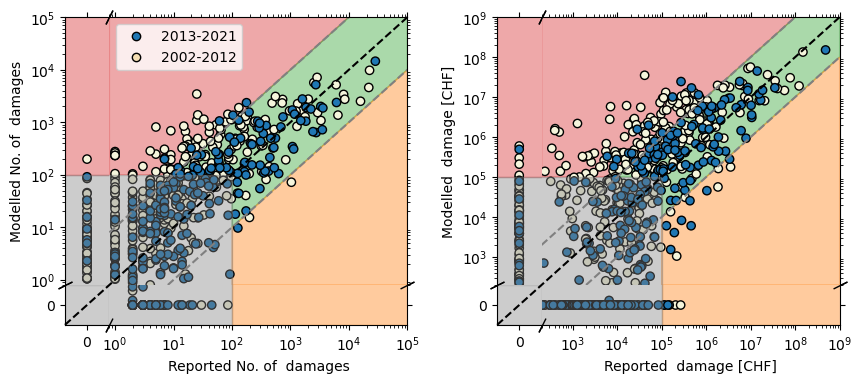

In [8]:
#Replicate Figure 8 from the publication to validate the impact dataset created above
fig = sc.plot_funcs.plot_skill_plot(imp_ds,PAA_lim=(0.8,1e5),MDR_lim=(200,1e9))

## Cross validation analysis

In [9]:
#load cross validation results (which is saved from scripts/calibration_main.py)
c_path = '%s%s_v%d' % ('KGV',haz_var, event_def_version)
CV_years=pd.read_csv(f'{data_dir}/out_files/calib_emp/CV/{c_path}_CV_years.csv',index_col=0).squeeze('columns')
df_CV_paramsMDR=pd.read_csv(f'{data_dir}/out_files/calib_emp/CV/{c_path}_CV_params.csv',index_col=0)
df_CV_paramsPAA=pd.read_csv(f'{data_dir}/out_files/calib_emp/CV/{c_path}_CV_paramsPAA.csv',index_col=0)

#if CV index starts with zero, add one to CV index
if CV_years.min()==0 and df_CV_paramsMDR.index.min()==0 and df_CV_paramsPAA.index.min()==0:
    CV_years = CV_years+1
    df_CV_paramsMDR.index = df_CV_paramsMDR.index+1
    df_CV_paramsPAA.index = df_CV_paramsPAA.index+1


In [10]:
#Introduce scaling factor to account for changing exposure (as in hail_main.py)
scale_factor_year = pd.read_csv(data_dir+'/out_files/constants/KGV_scale_factor.csv',index_col=0)
def scale_imp_df(imp_df,scale_factor_year,imp_var):
    imp_df_out = imp_df.copy(deep=True)
    scale_factor_str = 'scale_factor' if imp_var=='MDR' else 'scale_factorPAA'
    imp_df_out['imp_modelled_raw'] = imp_df_out['imp_modelled']
    imp_df_out['imp_modelled'] = scale_factor_year.loc[imp_df_out.date.dt.year,scale_factor_str].values*imp_df_out['imp_modelled'].values
    return imp_df_out


Cross validation split 1, validation years:[2002 2003 2004 2005]
Cross validation split 2, validation years:[2006 2007 2008 2009]
Cross validation split 3, validation years:[2010 2011 2012 2013]
Cross validation split 4, validation years:[2014 2015 2016 2017]
Cross validation split 5, validation years:[2018 2019 2020 2021]


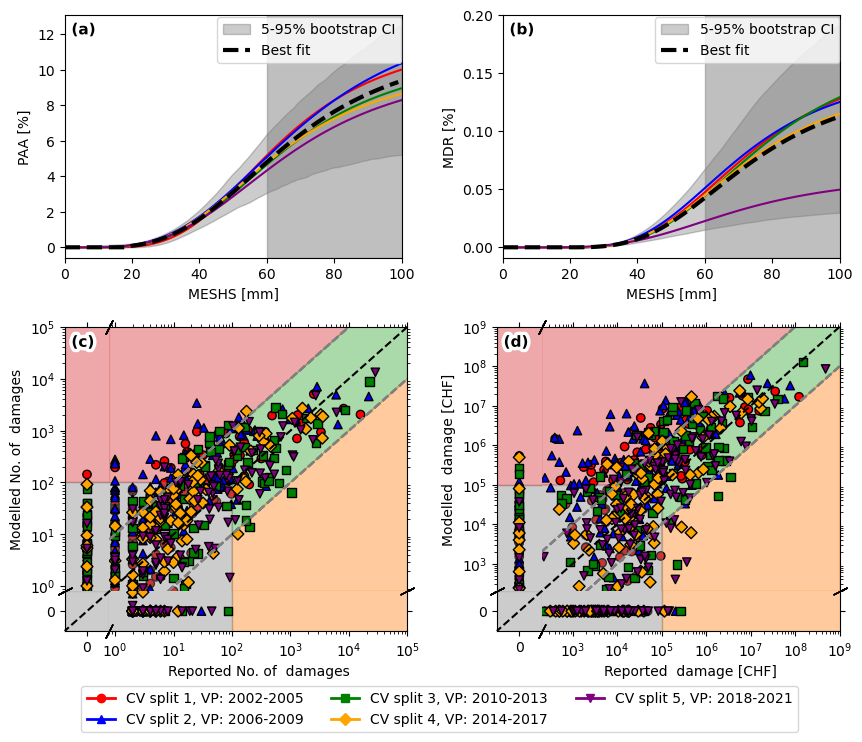

In [12]:
CV_splits = np.unique(CV_years)

#Set up colors and shapes for plotting
colors_5 = ['red','blue','green','orange','purple']
shapes_5 = ['o','^','s','D','v']


#Set up dataframe to save skill scores
skill_dict = {label : pd.DataFrame(index=CV_splits,columns=['rmse','rmsf','rmsf_weighted','FAR','POD','p_within_OOM','n_ev','rmsf_at'])
               for label in ['impf_CV_MDR','impf_CV_PAA','impf_default_PAA','impf_default_MDR']}

#Set up figure (including supfigure for Impact function plots)
fig = plt.figure(figsize=(10,8))
gs0 = gridspec.GridSpec(2,1, figure=fig,height_ratios=[0.8,1],hspace=0.25)
gs_funcs = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=gs0[0],wspace=0.0,
                                        hspace=0, width_ratios=[1,0.3,1])
axes_impf=np.array([0,0],dtype=object)
axes_impf[0]= fig.add_subplot(gs_funcs[0,0])
axes_impf[1]= fig.add_subplot(gs_funcs[0,2])

#Plot impact functions for PAA and MDR
for ax,imp_var,lbl in zip(axes_impf,['PAA','MDR'],['(a)','(b)']):
    #Plot bootstrapped impact functions
    df_boot_vals = globals()[f'df_boot_emanuel{imp_var}']
    df_boot_vals.loc[100,:] = df_boot_vals.loc[99,:] #Extend values to 100, for nicer plotting
    sc.plot_funcs.fill_df_quantile(df_boot_vals,0.05,0.95,ax,label="5-95% bootstrap CI")
    ax.set(xlim=(0,100),xlabel='MESHS [mm]',ylabel=f'{imp_var} [%]',
           ylim=(ax.get_ylim()[0],ax.get_ylim()[1]))
    ax.add_patch(Rectangle((60, ax.get_ylim()[0]), 100,
                           ax.get_ylim()[1]-ax.get_ylim()[0],
                           color="grey", alpha=0.5))

    #Plot best fit impact function
    imp_best_fit = globals()[f"imp_fun_set{imp_var}"].get_func(haz_type='HL')[0]
    ax.plot(imp_best_fit.mdd*imp_best_fit.paa*100, color = 'black',ls='--',
            label="Best fit",lw=3,zorder=5)

    #add labels
    txt = ax.text(0.02,0.97,lbl,transform=ax.transAxes,fontsize=11,
                    fontweight='bold',ha='left',va='top')
    txt.set_path_effects([withStroke(linewidth=5, foreground='w')])



zip_list = list(zip(['MDR','PAA'],[df_CV_paramsMDR,df_CV_paramsPAA],
                    [imp_measuredMDR,imp_measuredPAA],
                    [expMDR,expPAA],[xminMDR,xminPAA],
                    [dmg_threshMDR,dmg_threshPAA],
                    [axes_impf[1],axes_impf[0]],
                    [imp_dfMDR,imp_dfPAA]))
labels = list()
#Loop over each Cross Validation Split
for i,split in enumerate(CV_splits):
    #Define validation and calibration years
    years_calibration = CV_years.index.values[(CV_years!=split)]
    years_validation = CV_years.index.values[(CV_years==split)]
    label = f"CV split {split}, VP: {years_validation[0]}-{years_validation[-1]}"
    labels.append(label)
    print(f"Cross validation split {split}, validation years:{years_validation}")
    haz_sel = haz.select(date=(f"{years_validation.min()}-01-01",f"{years_validation.max()}-12-31"))


    #Loop over MDR and PAA
    imp_df_list = []
    for imp_var,df_CV_params,imp_measured, exp,xmin,dmg_thresh,ax_impf,impf_df_default_impf in zip_list:

        params = df_CV_params.loc[split,:].to_dict()
        imp_obs_now = imp_measured.select(dates=(f"{years_validation.min()}-01-01",f"{years_validation.max()}-12-31"))


        #plot impact function
        impf_set = ImpactFuncSet([sc.calib_opt.get_emanuel_impf(**params)])
        ax_impf.plot(impf_set.get_func(haz_type='HL')[0].mdd*100, color = colors_5[i],label=None)#label)

        imp_now = ImpactCalc(exp, impf_set, haz_sel).impact(save_mat=True)

        #create impact dataframe
        imp_df = sc.E.create_imp_df(imp_now,imp_obs_now,xmin)
        imp_df = scale_imp_df(imp_df,scale_factor_year,imp_var)
        imp_df_list.append(imp_df)

        #calculate skill measures
        rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev,rmsf_at = sc.E.calc_skill_scores(
            imp_df,dmg_thresh,calc_additional_scores=True)
        skill_dict[f"impf_CV_{imp_var}"].loc[split,:] = [rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev,rmsf_at]

        #create dictionary with evaluation metrics to pass to plotting function
        eval_dict = {var_name: globals()[var_name] for var_name in ["rmse","rmsf","rmsf_weighted",
                    "FAR","POD","p_within_OOM","n_ev","haz_var","exposure","impf"]}

        #Save skill scores caclulated with the default impact functions
        impf_default_now = impf_df_default_impf.loc[impf_df_default_impf.date.dt.year.isin(years_validation),:]
        impf_default_now = scale_imp_df(impf_default_now,scale_factor_year,imp_var)
        rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev,rmsf_at = sc.E.calc_skill_scores(
            impf_default_now,dmg_thresh,calc_additional_scores=True)
        skill_dict[f"impf_default_{imp_var}"].loc[split,:] = [rmse,rmsf,rmsf_weighted,FAR,POD,p_within_OOM,n_ev,rmsf_at]

    imp_ds = get_ds_from_imp_df(imp_df_list[0],imp_df_list[1])

    if i==0:
        fig1,axes = sc.plot_funcs.plot_skill_plot(imp_ds,PAA_lim=(0.8,1e5),MDR_lim=(200,1e9),unique_color=colors_5[i],ret_ax=True,gs_fig=(gs0[1],fig),labels=['(c)','(d)'])
    else:
        # case_studies_now = case_studies if split==4 else None
        _ = sc.plot_funcs.plot_skill_plot(imp_ds,PAA_lim=(0.8,1e5),MDR_lim=(200,1e9),unique_color=colors_5[i],gs_fig=(axes,fig),marker=shapes_5[i])

#add legend at the bottom
handles = [Line2D([0], [0], color=colors_5[i],marker=shapes_5[i], lw=2, label=label) for i,label in enumerate(labels)]


# handles, labels = axes_impf[0].get_legend_handles_labels()
#add legend at the bottom
fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.5,0.05))
for ax in axes_impf:
    ax.legend(loc='upper right',bbox_to_anchor=(1.02,1.02))

#save figure
fig.savefig(f"{out_dir}/paper1/figD1.png",dpi=300,bbox_inches='tight')

In [13]:
# Function to get a formatted table of skill scores
def format_table(tab,tab2, show_diff=True,add_VP=True):
    tab_out = pd.DataFrame(index=tab.index,columns=tab.columns)
    tab_out['VP'] = "" #add validation period column
    tab2_in = tab2-tab if show_diff else tab2
    sign_f = '+' if show_diff else ''
    for i in range(tab.shape[0]):
        for col in ['POD','FAR','p_within_OOM']:
            tab_out.loc[:,col].iloc[i] = f"{tab.iloc[i,:][col]:.0%} ({tab2_in.iloc[i,:][col]:{sign_f}.0%})"
        tab_out.loc[:,'VP'].iloc[i] = labels[i][15:]


    tab_out['n_ev'] = tab['n_ev']
    tab_out = tab_out.dropna(axis=1,how='all') #drop non-filled columns
    #print removed column names
    print(f"Removed columns: {list(tab.columns.difference(tab_out.columns))}")
    return tab_out

format_table(skill_dict['impf_CV_MDR'],skill_dict['impf_default_MDR'])

Removed columns: ['rmse', 'rmsf', 'rmsf_at', 'rmsf_weighted']


,FAR,POD,p_within_OOM,n_ev,VP
1,45% (+0%),79% (+0%),54% (+0%),67,2002-2005
2,60% (-5%),59% (+2%),39% (+4%),95,2006-2009
3,30% (+0%),73% (+0%),65% (+0%),60,2010-2013
4,20% (+1%),81% (+0%),74% (-1%),43,2014-2017
5,10% (+1%),82% (-6%),81% (-5%),62,2018-2021


In [14]:
tabMDR = format_table(skill_dict['impf_CV_MDR'],skill_dict['impf_default_MDR'],show_diff=False)
tabMDR.to_latex(f"{out_dir}/paper1/tab_CV_MDR.tex",index=True)
tabMDR

Removed columns: ['rmse', 'rmsf', 'rmsf_at', 'rmsf_weighted']


C:\Users\timschmi\AppData\Local\Temp\ipykernel_17632\94569806.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tabMDR.to_latex(f"{out_dir}/paper1/tab_CV_MDR.tex",index=True)


,FAR,POD,p_within_OOM,n_ev,VP
1,45% (45%),79% (79%),54% (54%),67,2002-2005
2,60% (56%),59% (61%),39% (43%),95,2006-2009
3,30% (30%),73% (73%),65% (65%),60,2010-2013
4,20% (21%),81% (81%),74% (74%),43,2014-2017
5,10% (11%),82% (76%),81% (75%),62,2018-2021


In [15]:
format_table(skill_dict['impf_CV_PAA'],skill_dict['impf_default_PAA'])

Removed columns: ['rmse', 'rmsf', 'rmsf_at', 'rmsf_weighted']


,FAR,POD,p_within_OOM,n_ev,VP
1,30% (+6%),100% (+0%),71% (-6%),41,2002-2005
2,49% (-0%),91% (+0%),52% (+0%),61,2006-2009
3,18% (-0%),93% (+0%),80% (+0%),45,2010-2013
4,11% (+1%),89% (+0%),86% (-0%),29,2014-2017
5,6% (-0%),96% (+0%),95% (+0%),38,2018-2021


In [16]:
tabPAA = format_table(skill_dict['impf_CV_PAA'],skill_dict['impf_default_PAA'],show_diff=False)
tabPAA.to_latex(f"{out_dir}/paper1/tab_CV_PAA.tex",index=True)
tabPAA

Removed columns: ['rmse', 'rmsf', 'rmsf_at', 'rmsf_weighted']


C:\Users\timschmi\AppData\Local\Temp\ipykernel_17632\3435893991.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tabPAA.to_latex(f"{out_dir}/paper1/tab_CV_PAA.tex",index=True)


,FAR,POD,p_within_OOM,n_ev,VP
1,30% (36%),100% (100%),71% (65%),41,2002-2005
2,49% (49%),91% (91%),52% (53%),61,2006-2009
3,18% (18%),93% (93%),80% (80%),45,2010-2013
4,11% (12%),89% (89%),86% (86%),29,2014-2017
5,6% (6%),96% (96%),95% (95%),38,2018-2021
